In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import os
import glob
from PIL import Image

2024-03-06 17:21:46.283352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '../raw_data/plate_24277'
extracted_channels = {}

In [3]:
# Define the path to the directory containing the extracted images for one channel
channel_dir = os.path.join(base_dir, 'Hoechst/24277-Hoechst')

# List all image files in the directory
image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

# Load and preprocess the images
images = []
for img_path in image_files:
    img = load_img(img_path, target_size=(260, 260))  # Resize to the size expected by EfficientNet
    img = img_to_array(img)
    img = preprocess_input(img)  # Preprocess the image
    images.append(img)
images = np.array(images)

## Testing CV2 for Image Stitching

Testing CV With 2 Images

In [4]:

def estimate_overlap(image1, image2):
    """
    Attempt to find keypoints and matches between two images.
    Returns the number of good matches as a simple overlap estimate.
    """
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Assuming good matches have distance less than a threshold (say, 50)
    good_matches = [m for m in matches if m.distance < 50]

    return len(good_matches)

def evaluate_image_quality(image):
    """
    Evaluate the image quality based on sharpness.
    This is a very simple heuristic that might not apply to all images.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the Laplacian variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    return laplacian_var

# Example usage for a pair of images
image1 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif')
image2 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s2_w15e4541e6-dfcb-4008-b9f0-7d9154c7dee6.tif')

# Estimate overlap
overlap_estimate = estimate_overlap(image1, image2)
print(f"Estimated overlap (good matches): {overlap_estimate}")

# Evaluate image quality
quality1 = evaluate_image_quality(image1)
quality2 = evaluate_image_quality(image2)
print(f"Image quality estimates (sharpness): {quality1}, {quality2}")

# Adjust Stitcher parameters if necessary and try stitching
stitcher = cv2.Stitcher_create()
stitcher.setPanoConfidenceThresh(0.5)  # Lower this threshold if stitching fails due to low confidence

# Try stitching the images
status, stitched_image = stitcher.stitch([image1, image2])
if status == cv2.Stitcher_OK:
    print("Stitching successful.")
    cv2.imshow('Stitched Image', stitched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Stitching failed.")

Estimated overlap (good matches): 0
Image quality estimates (sharpness): 0.34716511688985, 0.32120634356932737
Stitching failed.


testing CV with different confidence thresholds

In [5]:
# Example usage
example_image_paths = ['../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif', '../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s2_w15e4541e6-dfcb-4008-b9f0-7d9154c7dee6.tif']  # Update these paths
confidence_threshold = 0.5  # Adjust this threshold based on experimentation
stitched_image = stitch_images_with_custom_config(image_paths, confidence_threshold)

if stitched_image is not None:
    # Display or save the stitched image
    cv2.imshow('Stitched Image', stitched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # cv2.imwrite('path/to/save/stitched_output.jpg', stitched_image)

# Function to perform stitching with adjustable parameters
def stitch_images_with_custom_config(example_image_paths, confidence_threshold):
    # Load images
    images = [cv2.imread(img_path) for img_path in image_paths]

    # Check for successful image loading
    if any(img is None for img in images):
        print("Error loading one or more images.")
        return None

    # Create a Stitcher instance
    stitcher = cv2.Stitcher_create()

    # OpenCV versions prior to 4.5.0 may not support setting PanoConfidenceThresh directly in Python
    # For newer versions, you can try using stitcher.setPanoConfidenceThresh(confidence_threshold)
    # If this method is not available, you may need to adjust source code or explore alternative solutions

    # This is a placeholder for setting the confidence threshold, which might not be directly exposed
    # Check the OpenCV version and documentation for your installation
    # stitcher.setPanoConfidenceThresh(confidence_threshold)

    # Perform stitching
    status, stitched_image = stitcher.stitch(images)

    if status == cv2.Stitcher_OK:
        print("Stitching completed successfully.")
        return stitched_image
    else:
        print(f"Stitching failed with status {status}.")
        return None


NameError: name 'stitch_images_with_custom_config' is not defined

### Successful Stitching just by adding pictures to each other in a row

In [6]:
# Function to parse well information from filename
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

# Function to combine images
def combine_images(image_paths):
    images = [Image.open(img_path) for img_path in image_paths]
    # Assuming all images are of the same size, concatenate them horizontally (or vertically)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    composite = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        composite.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    return composite

# Assuming 'image_files' contains all image paths
well_to_images = {}
for image_path in image_files:
    well = parse_well_from_filename(os.path.basename(image_path))
    if well not in well_to_images:
        well_to_images[well] = []
    well_to_images[well].append(image_path)

# Combine images for each well into a composite image
composite_images = {well: combine_images(paths) for well, paths in well_to_images.items()}

In [7]:
type(composite_images)


dict

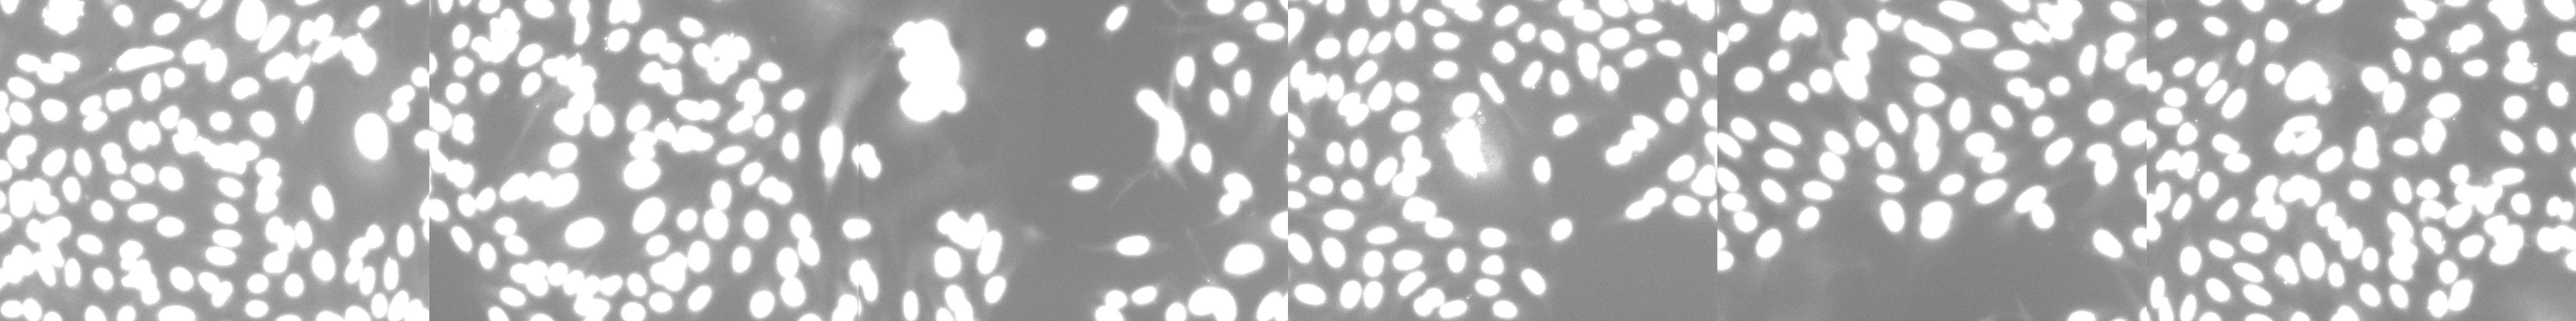

In [8]:
composite_images["a01"]

In [12]:
import cv2
import os
import glob
import numpy as np

def parse_well_from_filename(filename):
    # Extract the well identifier from the filename
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

def stitch_images(image_paths):
    # Load images
    images = [cv2.imread(img_path) for img_path in image_paths]
    # Create a Stitcher instance and use it to stitch images
    stitcher = cv2.Stitcher_create()
    status, stitched = stitcher.stitch(images)
    if status == cv2.Stitcher_OK:
        return True, stitched
    else:
        return False, None

# Assuming your images are in a directory and have a consistent naming scheme
image_directory = channel_dir
stitched_directory = os.path.join(image_directory, 'stitched_images')

# Create the directory for stitched images if it does not exist
os.makedirs(stitched_directory, exist_ok=True)

image_files = glob.glob(os.path.join(image_directory, '*.tif'))

# Group images by well
well_to_images = {}
for image_path in image_files:
    well = parse_well_from_filename(os.path.basename(image_path))
    if well not in well_to_images:
        well_to_images[well] = []
    well_to_images[well].append(image_path)

# Stitch images for each well
for well, paths in well_to_images.items():
    success, stitched_image = stitch_images(paths)
    if success:
        # Save the stitched image in the new directory
        save_path = os.path.join(stitched_directory, f"stitched_{well}.jpg")
        cv2.imwrite(save_path, stitched_image)
        print(f"Stitched image saved for well {well} in '{stitched_directory}'")
    else:
        print(f"Stitching failed for well {well}")

Stitching failed for well c22
Stitching failed for well f20
Stitching failed for well g09
Stitching failed for well p13
Stitching failed for well l07
Stitching failed for well o23
Stitching failed for well l04
Stitching failed for well j19
Stitching failed for well a01
Stitching failed for well i23
Stitching failed for well o19
Stitching failed for well p10
Stitching failed for well k23
Stitching failed for well f22
Stitching failed for well e19
Stitching failed for well m18
Stitching failed for well e01
Stitching failed for well e08
Stitching failed for well n10
Stitching failed for well l21
Stitching failed for well o13
Stitching failed for well i01
Stitching failed for well d15
Stitching failed for well f04
Stitching failed for well l08
Stitching failed for well b13
Stitching failed for well l14
Stitching failed for well k07
Stitching failed for well b16
Stitching failed for well f21
Stitching failed for well k19
Stitching failed for well n03
Stitching failed for well l09
Stitching 

KeyboardInterrupt: 

Testing the CV2 with only two images and seeing how well they matched

In [5]:
# Load two images
img1 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif')
img2 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s2_w15e4541e6-dfcb-4008-b9f0-7d9154c7dee6.tif')


In [6]:
# Initialize ORB detector
orb = cv2.ORB_create()

In [7]:
# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [8]:
# Create BFMatcher object and match descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

In [9]:
# Sort them in the order of their distance and draw first 10 matches
matches = sorted(matches, key=lambda x: x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

In [14]:

# Display the matches
cv2.imshow('Matches', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
cv2.imwrite('matches.jpg', img3)

True

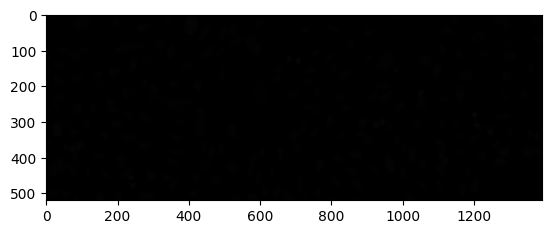

In [17]:
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
img3.dtype


dtype('uint8')

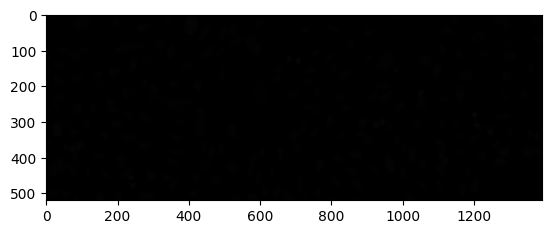

In [15]:
plt.imshow(img3, cmap='gray')

In [18]:
print("Min pixel value:", img3.min())
print("Max pixel value:", img3.max())

Min pixel value: 0
Max pixel value: 10


In [19]:
if img3.max() < 255:
    img3 = cv2.normalize(img3, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)


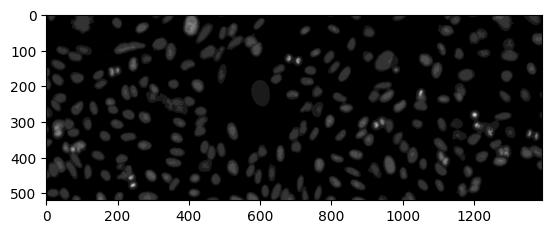

In [21]:
plt.imshow(img3, cmap="viridis")  # Correct way to display grayscale images
plt.show()

In [8]:
import cv2
import numpy as np
import glob

# This is a placeholder; replace it with your actual images' directory and naming pattern
image_directory = channel_dir
well_id = 'a01'
image_paths = glob.glob(f'{image_directory}/*_{well_id}_*.tif')

In [9]:
# Load images
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

In [10]:
type(images)

list

In [11]:
len(images)

6

In [16]:
def estimate_homography_sift(img1, img2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Create BFMatcher and match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    # Proceed if we have enough good matches
    min_match_count = 4
    if len(good) > min_match_count:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, mask
    else:
        print(f"Not enough good matches found - {len(good)}/{min_match_count}")
        return None, None
        

In [17]:
for i, img1 in enumerate(images):
    kp1, des1 = orb.detectAndCompute(img1, None)
    for j, img2 in enumerate(images):
        if i >= j:  # Avoid repeating comparisons
            continue
        kp2, des2 = orb.detectAndCompute(img2, None)
        H, mask = estimate_homography(kp1, des1, kp2, des2, bf)
        if H is not None:
            # Proceed with using H for your stitching logic
            relationships.append((i, j, H, np.sum(mask)))  # Example structure
        else:
            # Handle the case where not enough matches were found
            print(f"Skipping image pair ({i}, {j}) due to insufficient matches.")


Not enough matches are found - 0/4
Skipping image pair (0, 1) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (0, 2) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (0, 3) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (0, 4) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (0, 5) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (1, 2) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (1, 3) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (1, 4) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (1, 5) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (2, 3) due to insufficient matches.
Not enough matches are found - 0/4
Skipping image pair (2, 4) due to insufficient matches.

## Simply stitching it into 3,2 grids

In [20]:
from PIL import Image

def combine_images_into_grid(image_paths, grid_shape=(3, 2)):
    # Load images
    images = [Image.open(img_path) for img_path in image_paths]

    # Assuming all images are of the same size
    img_width, img_height = images[0].size

    # Calculate total grid size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]

    # Create a new image with the size of the entire grid
    grid_image = Image.new('RGB', (grid_width, grid_height))

    # Paste images into the grid
    for index, image in enumerate(images):
        # Calculate position of current image
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        x_offset = col * img_width
        y_offset = row * img_height

        # Paste the current image into the grid
        grid_image.paste(image, (x_offset, y_offset))

    return grid_image

# Example usage
# Assuming 'image_files' contains all image paths for a specific well
# Make sure to sort or arrange 'image_files' as needed before calling this function
well_id = "a01"  # Example well ID
image_paths = glob.glob(f'{image_directory}/*_{well_id}_*.tif')
composite_image = combine_images_into_grid(image_paths, grid_shape=(3, 2))

# To display the composite image inline (e.g., in a Jupyter notebook), use:
# composite_image.show()

# To save the composite image to a file
composite_image.save("composite_a01.jpg")

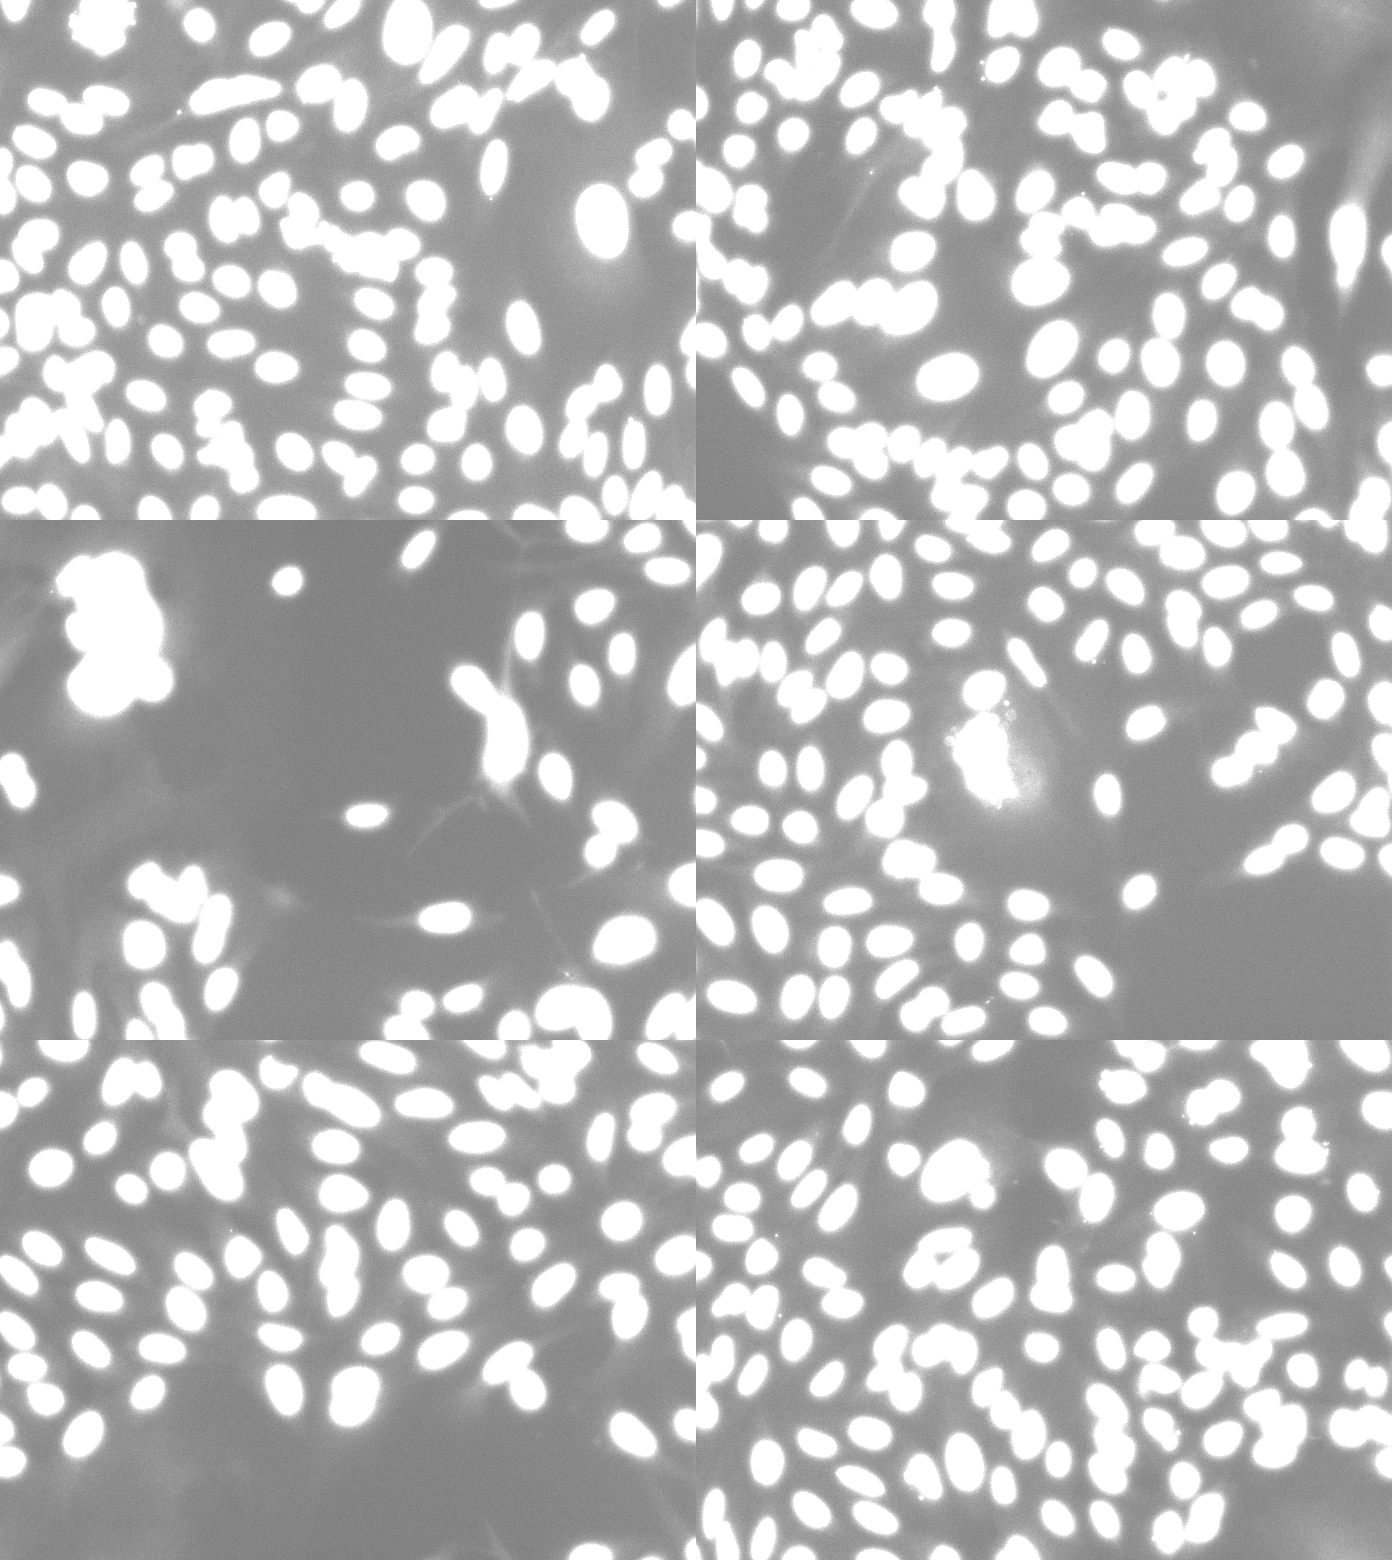

In [21]:
composite_image

## Doing the stitching with the PH_golgi

In [27]:
# Define the path to the directory containing the extracted images for one channel
channel_dir_2 = os.path.join(base_dir, 'Ph_golgi/24277-Ph_golgi')

# List all image files in the directory
Image_files_2 = [os.path.join(channel_dir_2, f) for f in os.listdir(channel_dir_2) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

# Load and preprocess the images
images2 = []
for img_path in Image_files_2:
    img = load_img(img_path, target_size=(260, 260))  # Resize to the size expected by EfficientNet
    img = img_to_array(img)
    img = preprocess_input(img)  # Preprocess the image
    images.append(img)
images2 = np.array(images2)

In [35]:
from PIL import Image

def combine_images_into_grid_2(image_paths, grid_shape=(3, 2)):
    # Load images
    images = [Image.open(img_path) for img_path in image_paths]

    # Assuming all images are of the same size
    img_width, img_height = images[0].size

    # Calculate total grid size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]

    # Create a new image with the size of the entire grid
    grid_image = Image.new('RGB', (grid_width, grid_height))

    # Paste images into the grid
    for index, image in enumerate(images):
        # Calculate position of current image
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        x_offset = col * img_width
        y_offset = row * img_height

        # Paste the current image into the grid
        grid_image.paste(image, (x_offset, y_offset))

    return grid_image

# Example usage
# Assuming 'image_files' contains all image paths for a specific well
# Make sure to sort or arrange 'image_files' as needed before calling this function
well_id = "a01"  # Example well ID
image_paths_2 = glob.glob(f"../raw_data/plate_24277/Ph_golgi/24277-Ph_golgi/*_a01_*.tif")
composite_image_2 = combine_images_into_grid_2(image_paths_2, grid_shape=(3, 2))

# To display the composite image inline (e.g., in a Jupyter notebook), use:
# composite_image.show()

# To save the composite image to a file
#composite_image.save("composite_a01.jpg")


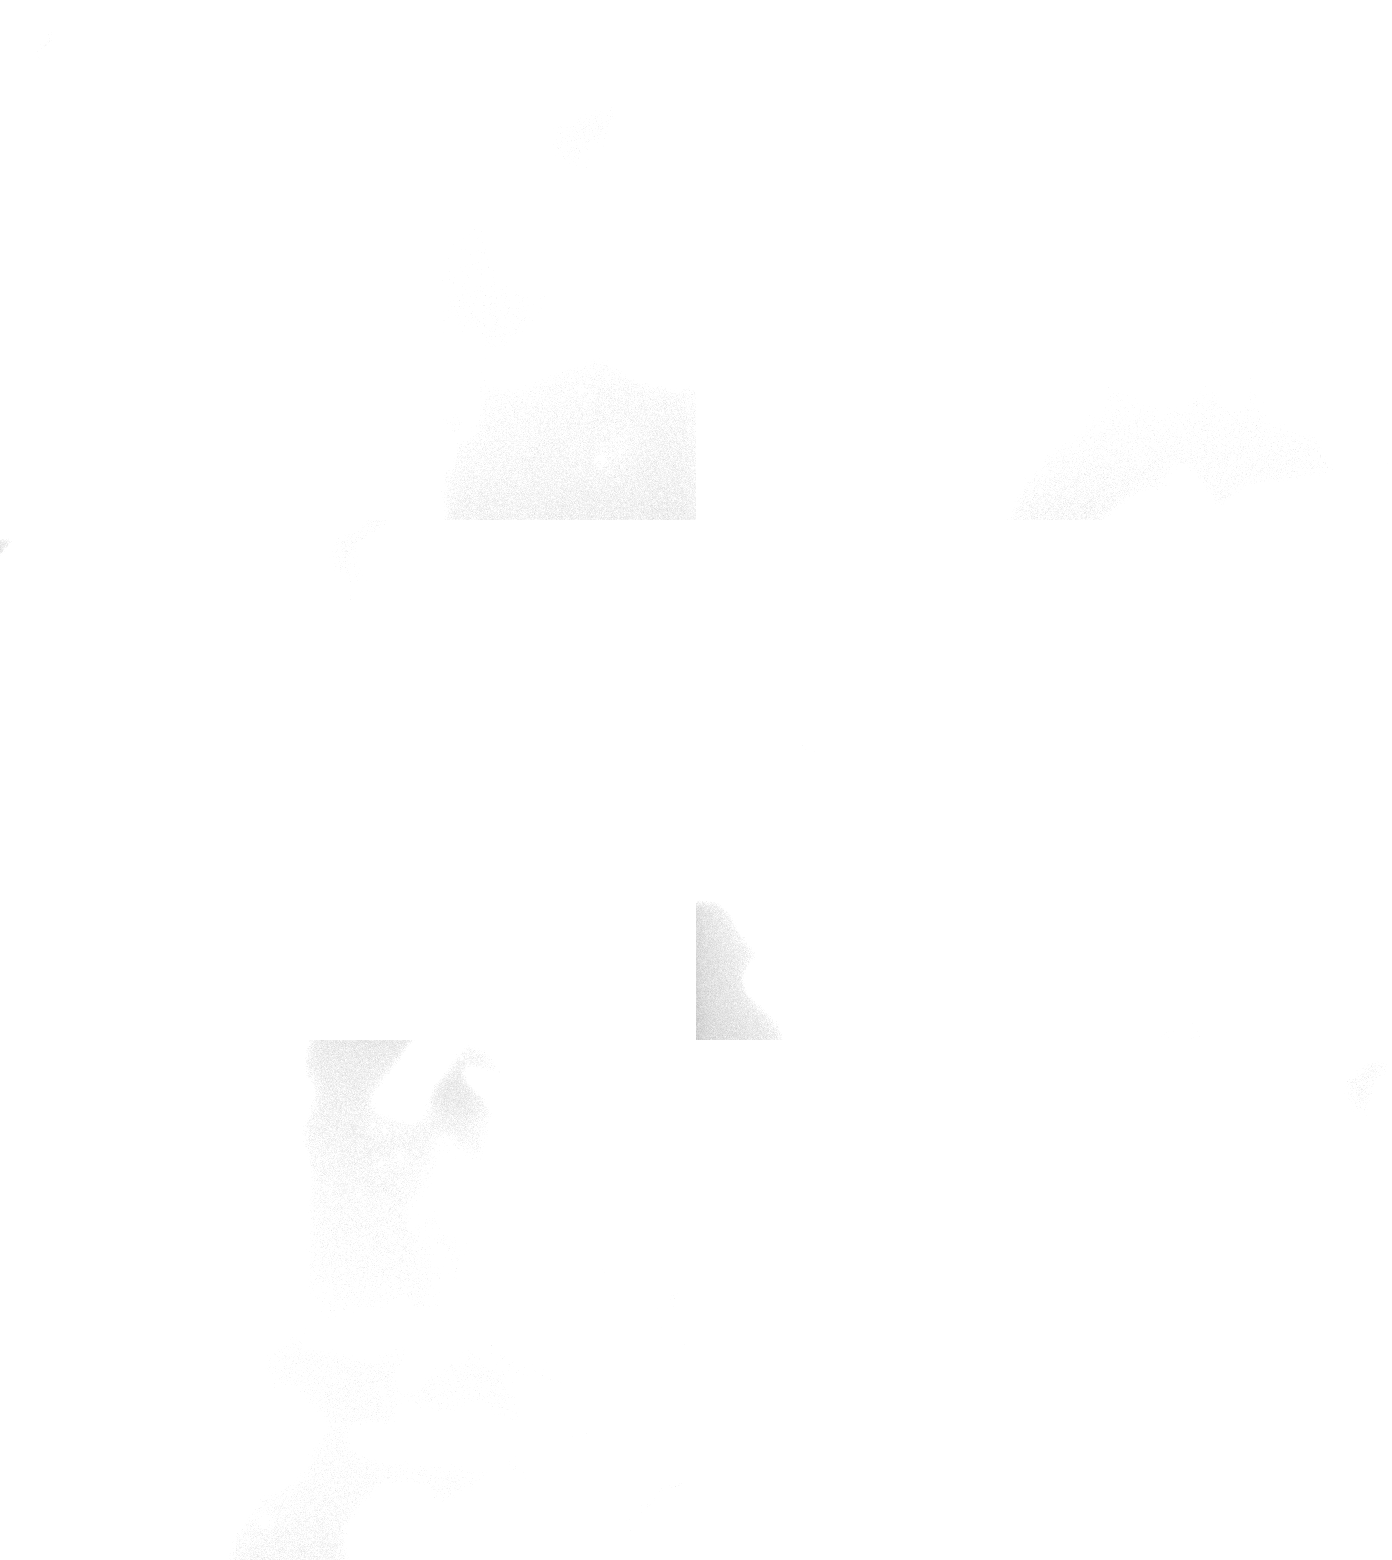

In [36]:
composite_image_2